In [9]:
import sqlite3
from datetime import datetime
import re
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

directory = '/mnt/processed/private/msds-pt2025a/lt6'
db_path = f'{directory}/database/lab1-backup7.db'


# Connect to the SQLite database
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

In [13]:
# NO NEEED TO RUN THIS SECTION THIS FOR OPTINIZING

# # SQL statement to create the view
# create_view_sql = """
# CREATE VIEW IF NOT EXISTS unique_releases AS
# SELECT DISTINCT
#     artist_name,
#     title,
#     genre,
#     year
# FROM masters;
# """

# # Execute the SQL statement
# cursor.execute(create_view_sql)

# # Add index
# # cursor.execute("CREATE INDEX idx_file_year_month ON masters(file_year, file_month)")
# cursor.execute("CREATE INDEX idx_year ON masters(year)")

# # Commit the changes
# conn.commit()


# create_table_sql = """
# CREATE TABLE masters_new AS
# SELECT *
# FROM masters
# WHERE file_year = year;
# """

# cursor.execute(create_table_sql)


# Drop the existing view if it exists
cursor.execute("DROP VIEW IF EXISTS unique_new_releases")

# Create the new view
cursor.execute("""
CREATE VIEW unique_new_releases AS
SELECT DISTINCT
    artist_name,
    title,
    genre,
    year
FROM masters_new
""")

conn.commit()

In [14]:
cursor.execute("SELECT COUNT(*) FROM unique_new_releases")
c = cursor.fetchone()[0]

print(c)

cursor.execute("SELECT * FROM unique_new_releases LIMIT 10")
columns = [description[0] for description in cursor.description]
results = cursor.fetchall()

df = pd.DataFrame(results, columns=columns)

74096


In [5]:
df

,artist_name,title,genre,year
0,Pet Shop Boys,Monkey Business,Electronic,2020
1,Matt Elliott,Farewell To All We Know,"Folk, World, & Country",2020
2,Carlo Giustini,L’abbaglio,Electronic,2020
3,Jasper James (3),Steel City Dance Discs Volume 13,Electronic,2020
4,DJ Anna,Galactic Highways,Electronic,2020
5,Kirk Degiorgio,Arc Mode EP,Electronic,2020
6,Morah,#010,Electronic,2020
7,AYU Acid,Crystal Maze EP,Electronic,2020
8,Happa (3),Blue 07,Electronic,2020
9,Bluematter,Real,Electronic,2020


# Discogs: How many times does an artist have a release?

In [15]:
# CUMULATIVE
def count_artist_releases(limit):
    cursor.execute("SELECT COUNT(*) FROM unique_new_releases")
    total_releases = cursor.fetchone()[0]

    cursor.execute(f"""
        SELECT
            artist_name,
            COUNT(*) AS release_count
        FROM unique_new_releases
        WHERE artist_name NOT IN ('Various', 'Unknown Artist', 'No Artist')
        GROUP BY artist_name
        ORDER BY release_count DESC
        LIMIT {limit}""")

    columns = [description[0] for description in cursor.description]
    results = cursor.fetchall()

    df = pd.DataFrame(results, columns=columns)
    df['percentage_of_total_releases'] = (df['release_count'] / total_releases) * 100

    # Return the DataFrame and the total releases
    return df, total_releases


# TOP 10 artists with releases

top_10_artists_df, total_releases = count_artist_releases(10)
print(f"Total Releases: {total_releases}")

top_10_artists_df

Total Releases: 74096


,artist_name,release_count,percentage_of_total_releases
0,The Jaffa Kid,63,0.085025
1,Iron Maiden,62,0.083675
2,Wallace Robert Holt,53,0.071529
3,Mathias Grassow,53,0.071529
4,Endeleas,53,0.071529
5,Armin van Buuren,53,0.071529
6,Steve Roach,51,0.068830
7,David Bowie,49,0.066130
8,Mick Chillage,48,0.064781
9,Elvis Presley,47,0.063431


In [16]:
def count_artist_per_month(year, month, limit):
    cursor.execute("SELECT COUNT(DISTINCT title) FROM masters_new WHERE year = file_year AND file_year = ? AND file_month = ?"
                   , (year, month))
    total_releases = cursor.fetchone()[0]

    # Execute an SQL query to retrieve the row count from the "masters" table
    cursor.execute(f"""
        SELECT 
            file_year AS year, 
            file_month AS month, 
            artist_name,
            COUNT(DISTINCT title) AS release_count
        FROM masters_new 
        WHERE 
            year = file_year AND
            year = ? AND month = ?
            AND (artist_name != 'Various'
            AND artist_name != 'Unknown Artist'
            AND artist_name != 'No Artist')
        GROUP BY artist_name
        ORDER BY release_count DESC
        LIMIT {limit}""", (year, month))

    columns = [description[0] for description in cursor.description]
    results = cursor.fetchall()

    df = pd.DataFrame(results, columns=columns)
    df['percentage_of_total_releases'] = (df['release_count'] / total_releases) * 100

    # Return the DataFrame and the total releases
    return df, total_releases


# TOP 10 for June 2020

top_artists_df, total_releases = count_artist_per_month(2020, 6, 10)
print(f"Total releases for month: {total_releases}")
top_artists_df

Total releases for month: 9389


,year,month,artist_name,release_count,percentage_of_total_releases
0,2020,6,Pain Jerk,30,0.319523
1,2020,6,Elio Varesse,27,0.287571
2,2020,6,Thomas Park,22,0.234317
3,2020,6,Peshay,18,0.191714
4,2020,6,Celer,16,0.170412
5,2020,6,etherinterference,12,0.127809
6,2020,6,Mystified,12,0.127809
7,2020,6,Steve Roach,11,0.117158
8,2020,6,oliviaway,10,0.106508
9,2020,6,Kevin Drumm,10,0.106508


# Discogs: Most released genre?

In [17]:
# CUMULATIVE
def count_genre_releases(limit):
    cursor.execute("SELECT COUNT(*) FROM unique_new_releases")
    total_releases = cursor.fetchone()[0]

    cursor.execute(f"""
        SELECT
            genre,
            COUNT(*) AS release_count
        FROM unique_new_releases
        GROUP BY genre
        ORDER BY release_count DESC
        LIMIT {limit}""")

    columns = [description[0] for description in cursor.description]
    results = cursor.fetchall()

    df = pd.DataFrame(results, columns=columns)
    df['percentage_of_total_releases'] = (df['release_count'] / total_releases) * 100

    # Return the DataFrame and the total releases
    return df, total_releases


# TOP 10 GENRES

top_genres_df, total_releases = count_genre_releases(10)
print(f"Total releases: {total_releases}")
top_genres_df

Total releases: 74096


,genre,release_count,percentage_of_total_releases
0,Electronic,34409,46.438404
1,Rock,26132,35.267761
2,Hip Hop,3800,5.128482
3,Pop,2728,3.681710
4,Jazz,2348,3.168862
5,"Folk, World, & Country",1402,1.892140
6,Funk / Soul,1062,1.433276
7,Classical,587,0.792216
8,Reggae,469,0.632963
9,Stage & Screen,419,0.565483


# Discogs: Month x Releases

In [18]:
def get_monthly_release_counts():
    # Execute the SQL query
    cursor.execute("""
        SELECT
            file_year || '-' || file_month AS year_month,
            COUNT(DISTINCT title) AS release_count
        FROM masters_new
        GROUP BY year_month
        ORDER BY release_count DESC;
    """)

    # Fetch all the results
    results = cursor.fetchall()

    # Create a DataFrame with the results
    df = pd.DataFrame(results, columns=['year_month', 'release_count'])

    # Return the DataFrame
    return df


monthly_releases_df = get_monthly_release_counts()
monthly_releases_df

,year_month,release_count
0,2020-12,24493
1,2021-12,22419
2,2020-11,21765
3,2022-12,21330
4,2021-11,19799
5,2020-10,18968
6,2022-11,18847
7,2021-10,17437
8,2020-9,16246
9,2022-10,16150


# Discogs x Reddit (Submissions + Comments)

In [19]:
def remove_punctuation(text):
    # This will remove all punctuation from the text
    return re.sub(r'['+string.punctuation+']', '', text)

In [20]:
def count_reddit_submissions_keyword(keyword, year, month):
    keyword = remove_punctuation(keyword)
    month_str = f"{month:02d}"  # Ensure month is two digits
    year_str = str(year)
    keyword_pattern = f'%{keyword}%'

    # Query to count and sum scores for submissions
    sql_submissions = """
        SELECT
            COALESCE(COUNT(*), 0) as submission_count,
            COALESCE(SUM(score), 0) as submission_upscore
        FROM reddit_submissions
        WHERE strftime('%m', created_utc) = ?
          AND strftime('%Y', created_utc) = ?
          AND (title LIKE ? OR selftext LIKE ?)
    """

    # Query to count and sum scores for comments
    sql_comments = """
        SELECT
            COALESCE(COUNT(*), 0) as comment_count,
            COALESCE(SUM(score), 0) as comment_upscore
        FROM reddit_comments
        WHERE strftime('%m', created_utc) = ?
          AND strftime('%Y', created_utc) = ?
          AND body LIKE ?
    """

    # Execute the query for submissions
    cursor.execute(sql_submissions, (month_str, year_str, keyword_pattern, keyword_pattern))
    submissions_result = cursor.fetchone()

    # Execute the query for comments
    cursor.execute(sql_comments, (month_str, year_str, keyword_pattern))
    comments_result = cursor.fetchone()

    # Create a DataFrame with the results
    df = pd.DataFrame({
        'keyword': keyword,
        'submission_count': [submissions_result[0]],
        'submission_upscore': [submissions_result[1]],
        'comment_count': [comments_result[0]],
        'comment_upscore': [comments_result[1]],
    })

    # Calculate totals and add them to the DataFrame
    df['total_count'] = df['submission_count'] + df['comment_count']
    df['total_upscore'] = df['submission_upscore'] + df['comment_upscore']

    return df


In [21]:
count_reddit_submissions_keyword('Taylor Swift', 2020, 1)

,keyword,submission_count,submission_upscore,comment_count,comment_upscore,total_count,total_upscore
0,Taylor Swift,60,722,0,0,60,722


In [32]:
def get_top_artists_scores(year):
    monthly_top_count = []
    monthly_top_upscore = []

    # Get top 10 artists - based on most number of releases cumulatively
    # Needed to limit because of time
    top_artists_df, total_releases = count_artist_releases(10)
    unique_artists = top_artists_df['artist_name']

    for month in range(1, 13):
        print(f'Processing month ({month})')
        month_results = []
        i = 0
        for artist in unique_artists:
            i += 1
            df = count_reddit_submissions_keyword(artist, year, month)
            month_results.append(df)

        all_results_df = pd.concat(month_results, ignore_index=True)
        all_results_df['year'] = year
        all_results_df['month'] = month

        top_count_df = all_results_df.nlargest(10, 'total_count')
        top_upscore_df = all_results_df.nlargest(10, 'total_upscore')

        monthly_top_count.append(top_count_df)
        monthly_top_upscore.append(top_upscore_df)

    return monthly_top_count, monthly_top_upscore

Processing month (1)
Processing month (2)
Processing month (3)
Processing month (4)
Processing month (5)
Processing month (6)
Processing month (7)
Processing month (8)
Processing month (9)
Processing month (10)
Processing month (11)
Processing month (12)


<Figure size 2000x1000 with 0 Axes>

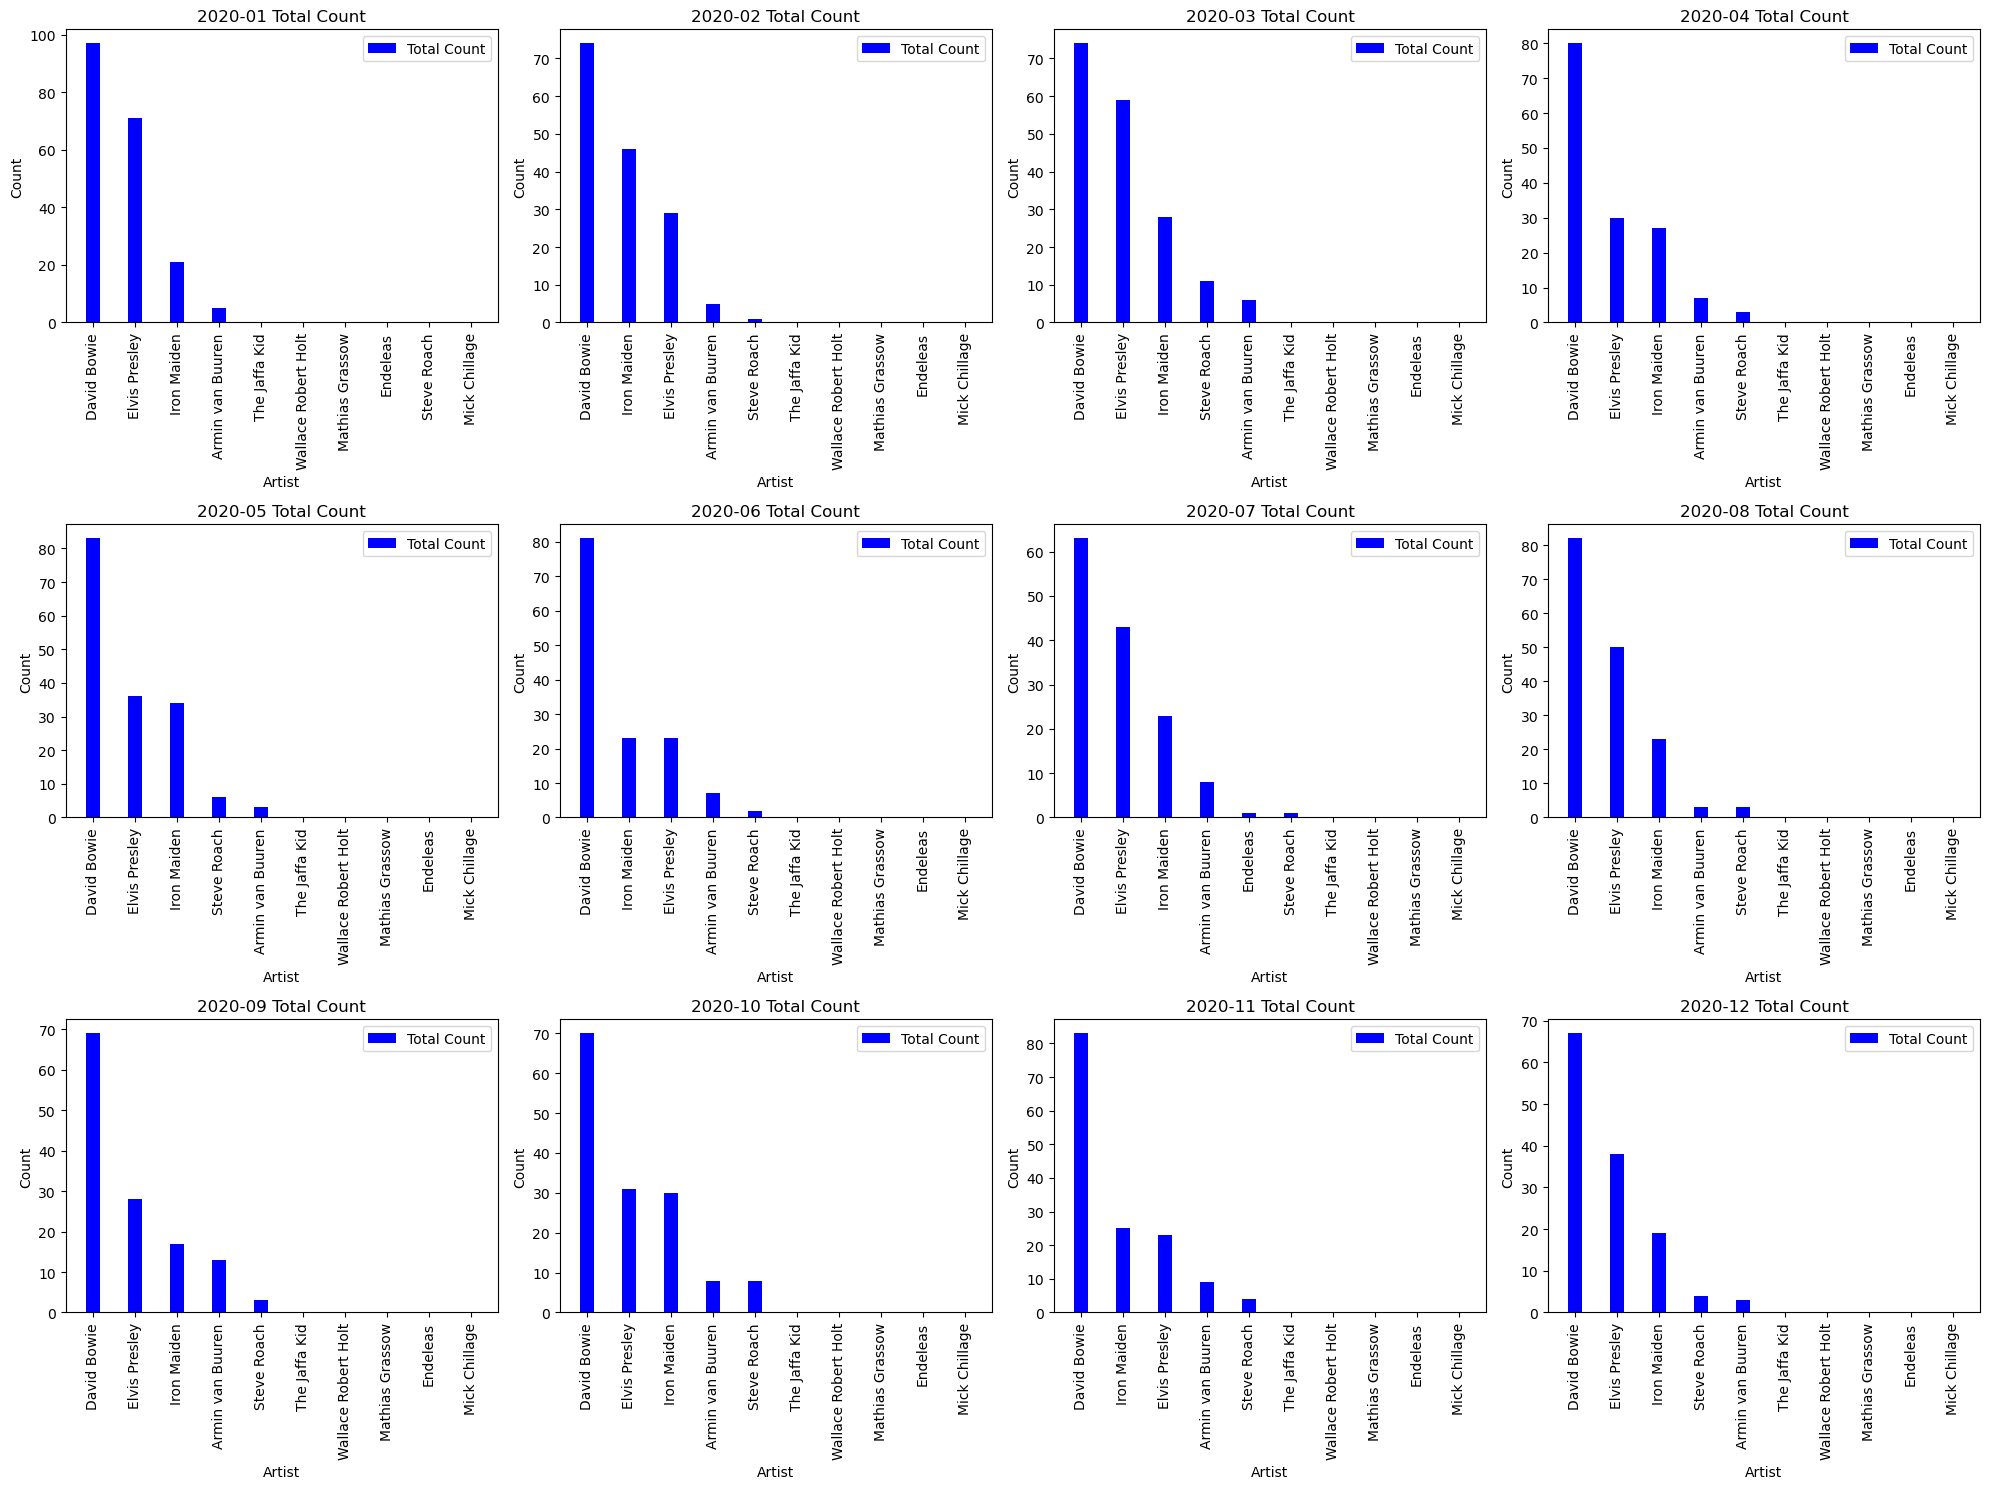

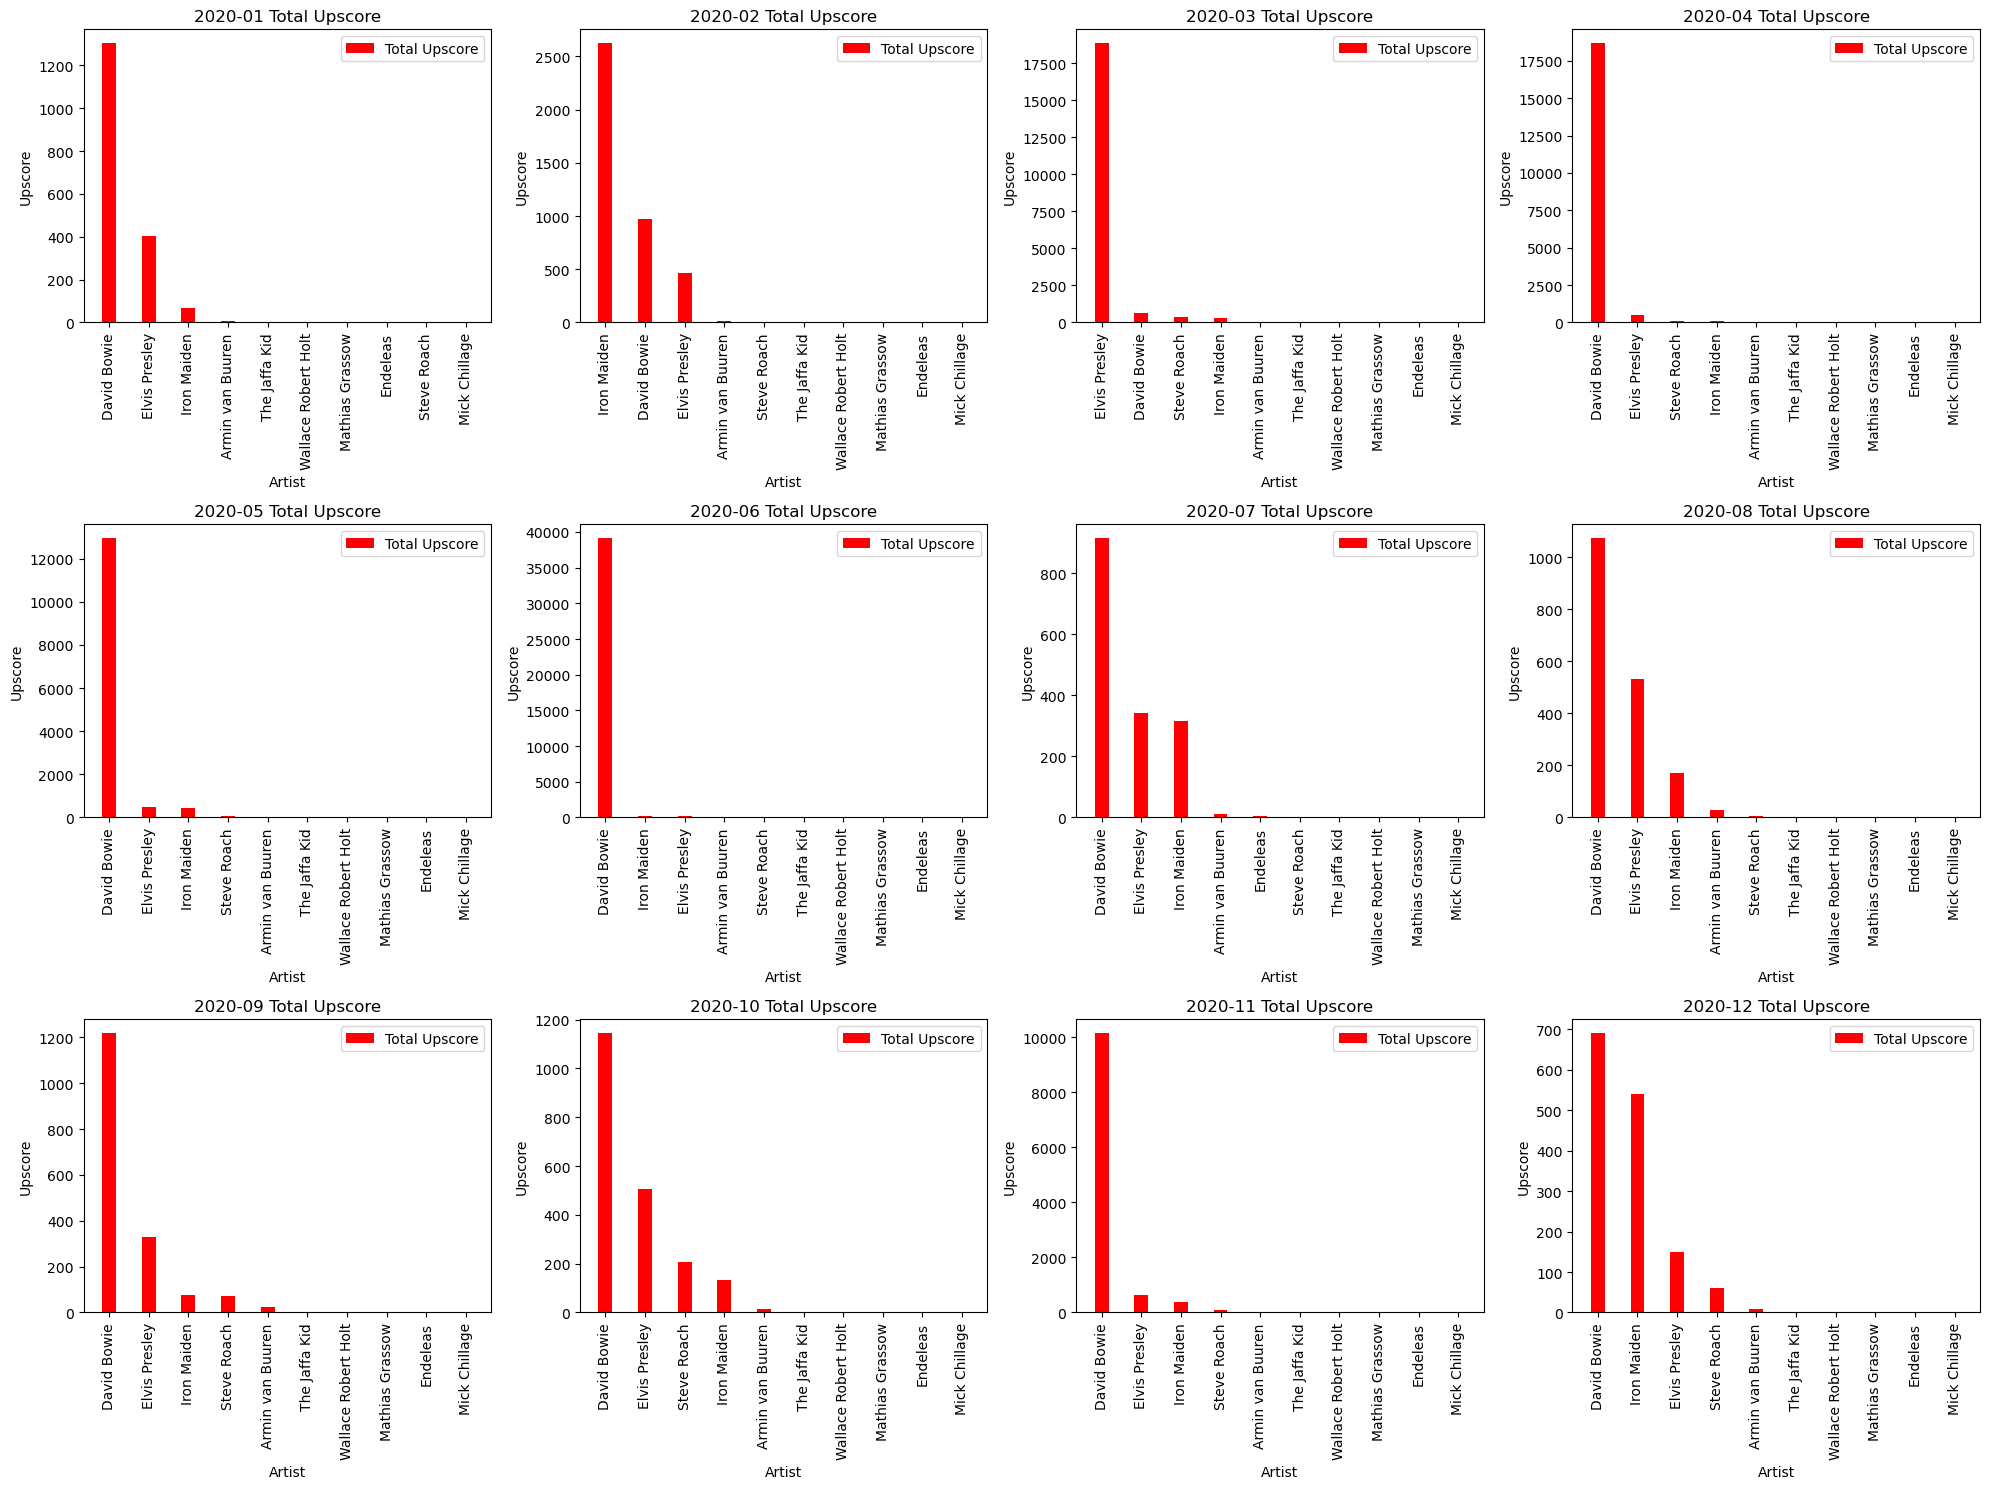

In [33]:
year = 2020
# Get the top artists for all months
monthly_top_count, monthly_top_upscore = get_top_artists_scores(year)

# We can now proceed to plot these. Here's an example of how you might plot the top counts.
plt.figure(figsize=(20, 10))

bar_width = 0.35

# Plot for total counts
plt.figure(figsize=(20, 15))
for i, count_df in enumerate(monthly_top_count, 1):
    index = np.arange(len(count_df['keyword']))
    plt.subplot(3, 4, i)
    plt.bar(index, count_df['total_count'], bar_width, color='b', label='Total Count')
    plt.xlabel('Artist')
    plt.ylabel('Count')
    plt.title(f'2020-{i:02d} Total Count')
    plt.xticks(index, count_df['keyword'], rotation=90)
    plt.legend()

plt.tight_layout()
plt.show()

# Plot for total upscores
plt.figure(figsize=(20, 15))
for i, upscore_df in enumerate(monthly_top_upscore, 1):
    index = np.arange(len(upscore_df['keyword']))
    plt.subplot(3, 4, i)
    plt.bar(index, upscore_df['total_upscore'], bar_width, color='r', label='Total Upscore')
    plt.xlabel('Artist')
    plt.ylabel('Upscore')
    plt.title(f'{year}-{i:02d} Total Upscore')
    plt.xticks(index, upscore_df['keyword'], rotation=90)
    plt.legend()

plt.tight_layout()
plt.show()


# Combine all the monthly DataFrames for count and upscore into two separate DataFrames
all_top_count_df = pd.concat(monthly_top_count).reset_index(drop=True)
all_top_upscore_df = pd.concat(monthly_top_upscore).reset_index(drop=True)

# Export to CSV
all_top_count_df.to_csv(f'top_artists_by_count_{year}.csv', index=False)
all_top_upscore_df.to_csv(f'top_artists_by_upscore_{year}.csv', index=False)

In [ ]:
def get_top_artists_by_month_scores(year):
    monthly_top_count = []
    monthly_top_upscore = []

    for month in range(1, 13):
        print(f'Processing month ({month})')

        # Get top 10 artists - based on most number of releases for the month
        # Needed to limit because of time
        top_artists_df, total_releases = count_artist_per_month(year, month, 10)
        unique_artists = top_artists_df['artist_name']

        month_results = []
        i = 0
        for artist in unique_artists:
            i += 1
            df = count_reddit_submissions_keyword(artist, year, month)
            if not df.empty:
                month_results.append(df)
            else:
                print(f"No results for artist {artist} in month {month:02d}")

        if month_results:
            all_results_df = pd.concat(month_results, ignore_index=True)
            all_results_df['release_count'] = top_artists_df['release_count']
            all_results_df['year'] = year
            all_results_df['month'] = month

            top_count_df = all_results_df.nlargest(10, 'total_count')
            top_upscore_df = all_results_df.nlargest(10, 'total_upscore')

            monthly_top_count.append(all_results_df.nlargest(10, 'total_count'))
            monthly_top_upscore.append(all_results_df.nlargest(10, 'total_upscore'))
        else:
            print(f"No results to concatenate for month {month:02d}")

    return monthly_top_count, monthly_top_upscore


year = 2020
# Get the top artists for all months
monthly_top_count, monthly_top_upscore = get_top_artists_by_month_scores(year)

# We can now proceed to plot these. Here's an example of how you might plot the top counts.
plt.figure(figsize=(20, 10))

bar_width = 0.35

# Plot for total counts
plt.figure(figsize=(20, 15))
for i, count_df in enumerate(monthly_top_count, 1):
    index = np.arange(len(count_df['keyword']))
    plt.subplot(3, 4, i)
    plt.bar(index, count_df['total_count'], bar_width, color='b', label='Total Count')
    plt.xlabel('Artist')
    plt.ylabel('Count')
    plt.title(f'2020-{i:02d} Total Count')
    plt.xticks(index, count_df['keyword'], rotation=90)
    plt.legend()

plt.tight_layout()
plt.show()

# Plot for total upscores
plt.figure(figsize=(20, 15))
for i, upscore_df in enumerate(monthly_top_upscore, 1):
    index = np.arange(len(upscore_df['keyword']))
    plt.subplot(3, 4, i)
    plt.bar(index, upscore_df['total_upscore'], bar_width, color='r', label='Total Upscore')
    plt.xlabel('Artist')
    plt.ylabel('Upscore')
    plt.title(f'{year}-{i:02d} Total Upscore')
    plt.xticks(index, upscore_df['keyword'], rotation=90)
    plt.legend()

plt.tight_layout()
plt.show()

# Combine all the monthly DataFrames for count and upscore into two separate DataFrames
all_top_count_df = pd.concat(monthly_top_count).reset_index(drop=True)
all_top_upscore_df = pd.concat(monthly_top_upscore).reset_index(drop=True)

# Export to CSV
all_top_count_df.to_csv(f'top_artists_by_month_by_count_{year}.csv', index=False)
all_top_upscore_df.to_csv(f'top_artists_by_month_by_upscore_{year}.csv', index=False)

Processing month (1)
Processing month (2)
Processing month (3)
Processing month (4)
Processing month (5)
Processing month (6)
Processing month (7)
Processing month (8)
Processing month (9)
Processing month (10)
Processing month (11)
Processing month (12)


In [ ]:
def get_top_genre_scores(year):
    monthly_top_count = []
    monthly_top_upscore = []

    # Get top 10 genres - based on most number of releases cumulatively
    # Needed to limit because of time
    top_genres_df, total_releases = count_genre_releases(10)
    unique_genres = top_genres_df['genre']

    for month in range(1, 13):
        print(f'Processing month ({month})')
        month_results = []    
        i = 0
        for genre in unique_genres:
            i += 1
            df = count_reddit_submissions_keyword(genre, year, month)
            month_results.append(df)

        all_results_df = pd.concat(month_results, ignore_index=True)
        all_results_df['year'] = year
        all_results_df['month'] = month

        top_count_df = all_results_df.nlargest(10, 'total_count')
        top_upscore_df = all_results_df.nlargest(10, 'total_upscore')

        monthly_top_count.append(top_count_df)
        monthly_top_upscore.append(top_upscore_df)

    return monthly_top_count, monthly_top_upscore

year = 2020
# Get the top genres for all months
monthly_top_count, monthly_top_upscore = get_top_genre_scores(year)

# We can now proceed to plot these. Here's an example of how you might plot the top counts.
plt.figure(figsize=(20, 10))

bar_width = 0.35

# Plot for total counts
plt.figure(figsize=(20, 15))
for i, count_df in enumerate(monthly_top_count, 1):
    index = np.arange(len(count_df['keyword']))
    plt.subplot(3, 4, i)
    plt.bar(index, count_df['total_count'], bar_width, color='b', label='Total Count')
    plt.xlabel('Genre')
    plt.ylabel('Count')
    plt.title(f'2020-{i:02d} Total Count')
    plt.xticks(index, count_df['keyword'], rotation=90)
    plt.legend()

plt.tight_layout()
plt.show()

# Plot for total upscores
plt.figure(figsize=(20, 15))
for i, upscore_df in enumerate(monthly_top_upscore, 1):
    index = np.arange(len(upscore_df['keyword']))
    plt.subplot(3, 4, i)
    plt.bar(index, upscore_df['total_upscore'], bar_width, color='r', label='Total Upscore')
    plt.xlabel('Artist')
    plt.ylabel('Upscore')
    plt.title(f'{year}-{i:02d} Total Upscore')
    plt.xticks(index, upscore_df['keyword'], rotation=90)
    plt.legend()

plt.tight_layout()
plt.show()


# Combine all the monthly DataFrames for count and upscore into two separate DataFrames
all_top_count_df = pd.concat(monthly_top_count).reset_index(drop=True)
all_top_upscore_df = pd.concat(monthly_top_upscore).reset_index(drop=True)

# Export to CSV
all_top_count_df.to_csv(f'top_genres_by_count_{year}.csv', index=False)
all_top_upscore_df.to_csv(f'top_genres_by_upscore_{year}.csv', index=False)